In [2]:
!pip install cvxopt==1.2.5

     |████████████████████████████████| 3.1 MB 1.4 MB/s eta 0:00:01


In [4]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

In [10]:
dataset = read_csv('SP500Data.csv',index_col=0)
dataset.head()
sp500 = dataset.columns
len(sp500)

502

In [11]:

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(448, 498)

In [13]:
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


In [14]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [15]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [16]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

In [17]:

    
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [18]:
#Calulate linkage
#Clustering Returns Z=[stock_1, stock_2, distance, sample_count]
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([24.        , 25.        ,  0.09110116,  2.        ])

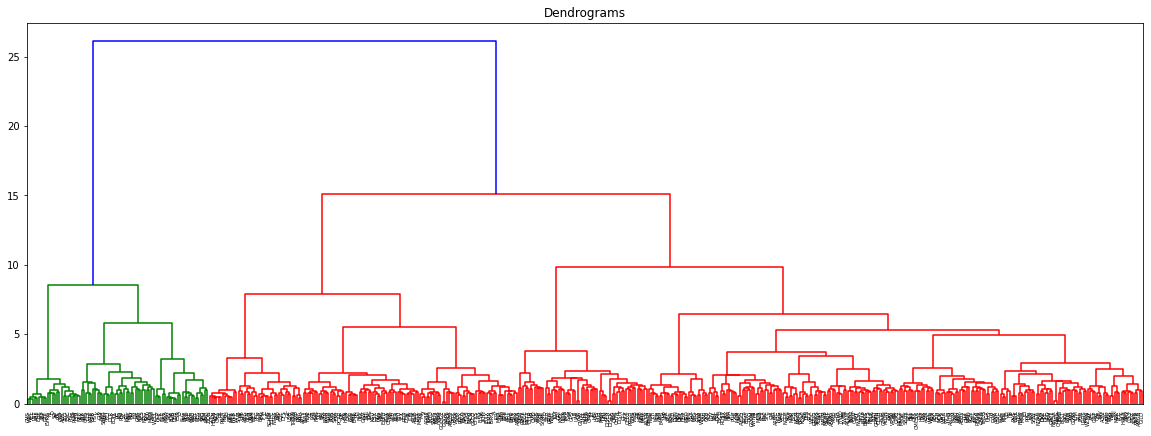

In [19]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link,labels = X.columns)
plt.show()

In [20]:
# 'quasi-diagonalization' is a process usually known as matrix seriation and which can be performed using hierarchical clustering. 
# This process reorganize the covariance matrix so similar investments will be placed together.


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [21]:
#Recursive Bi-Section
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [22]:
#Compare it to Markowitz -- MinVar (MVP pulled from fin-ml)
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [23]:
#Get all weights for all pfs
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [24]:
portfolios = get_all_portfolios(returns)

Text(0.5, 1.0, 'HRP')

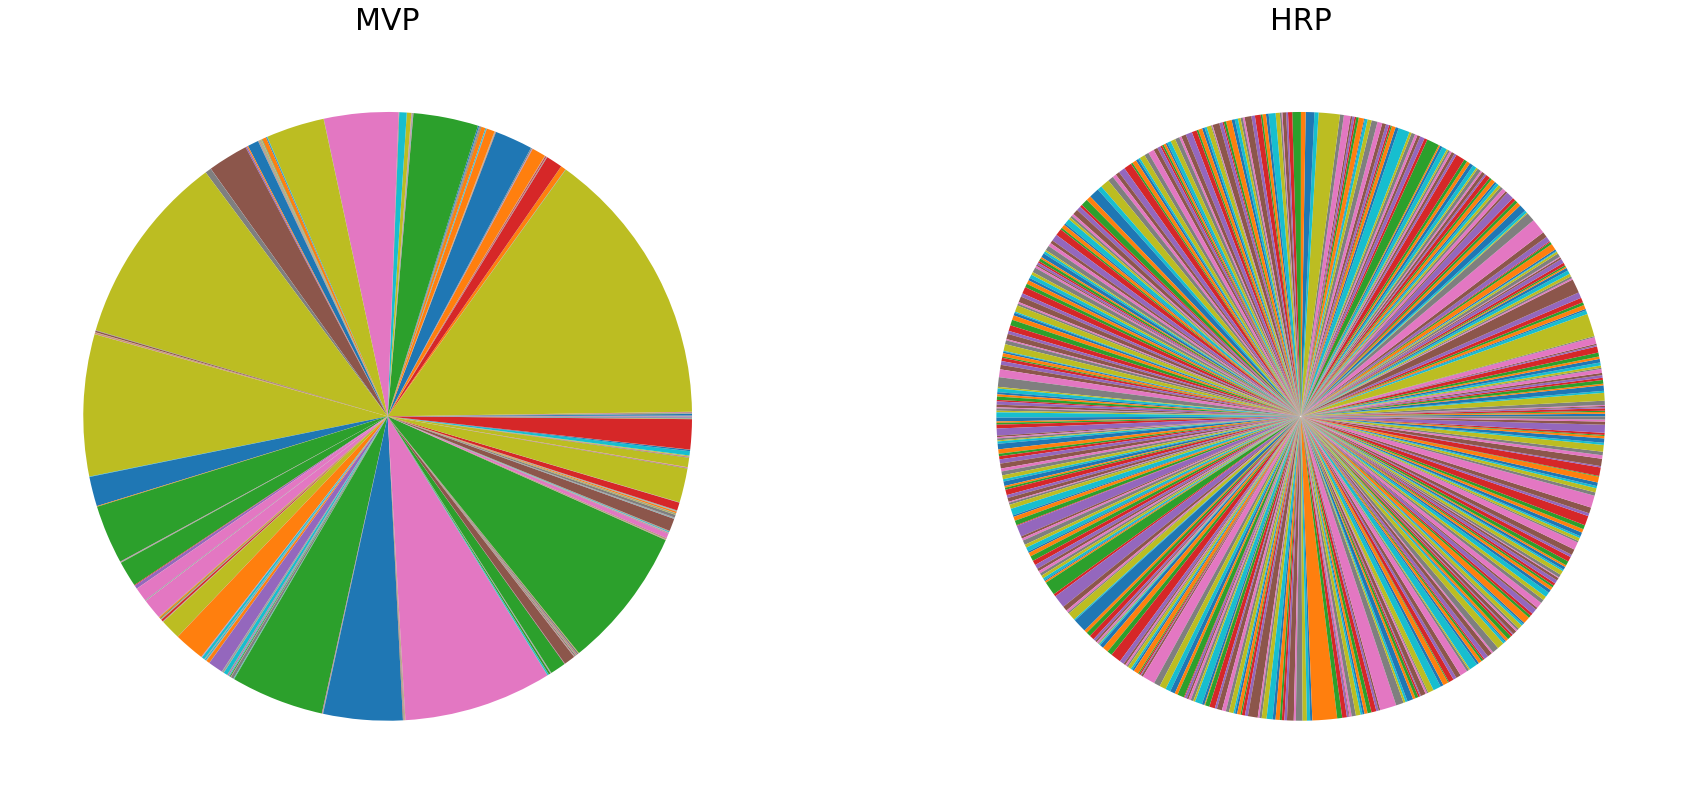

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [26]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

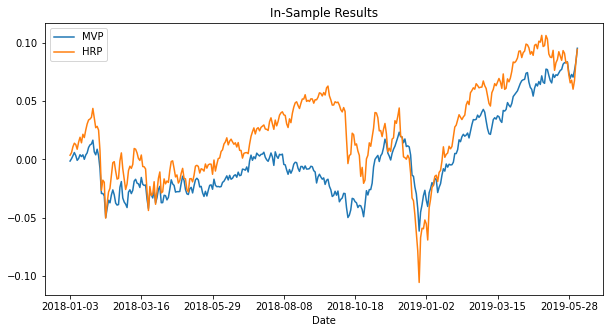

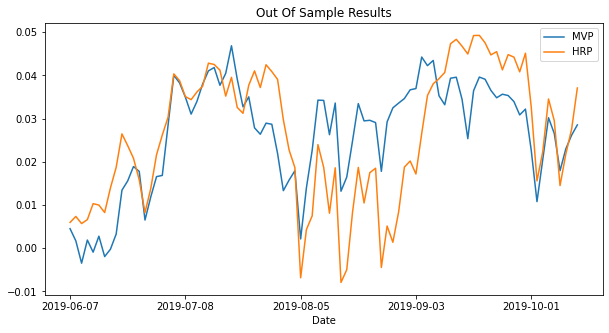

In [27]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

In [28]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.085516,0.785019
HRP,0.126944,0.523599


In [29]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.102761,0.786621
HRP,0.125610,0.836159
